In [127]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, f1_score

from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
import tensorflow as tf

### Read spam emails:

In [79]:
spam_file_paths = glob.iglob('../input/harvardspamemailenron/data/spam/**')
df_spam = pd.DataFrame(columns=['text', 'label'])

In [80]:
for file_path in spam_file_paths:
    text = ''
    with open(file_path, 'r') as file:
        for line in file:
            text += line
        df_spam = pd.concat([df_spam, pd.DataFrame({'text': text, 'label': [1]})], ignore_index=True)

In [81]:
df_spam.head()

,text,label
0,Subject: netgoodssale . com - electronic produ...,1
1,Subject: failure notice\nhi . this is the qmai...,1
2,Subject: popular mechanics : do you need a fri...,1
3,Subject: \nhtml\nbody\npfont face = arialbufon...,1
4,Subject: why pay more when you can pay less ! ...,1


### Read ham emails:

In [82]:
ham_file_paths = glob.iglob('../input/harvardspamemailenron/data/ham/**')
df_ham = pd.DataFrame(columns=['text', 'label'])

In [83]:
for file_path in ham_file_paths:
    text = ''
    with open(file_path, 'r') as file:
        for line in file:
            text += line

        df_ham = pd.concat([df_ham, pd.DataFrame({'text': text, 'label': [0]})], ignore_index=True)

In [84]:
df_ham.head()

,text,label
0,Subject: re : wolf - reply - reply - reply\nwr...,0
1,Subject: hilcorp old ocean\ni have continued t...,0
2,Subject: merchanting metals update\nseveral re...,0
3,"Subject: meter 6461 , concorde churchill\none ...",0
4,Subject: weekly deal report\nattached is the w...,0


## Explore Data

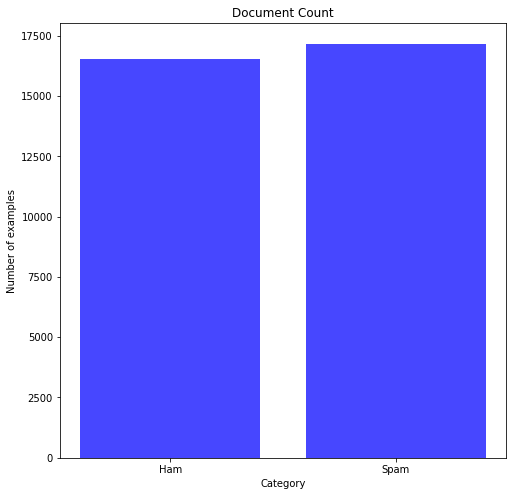

In [85]:
# Set size of plot:
plt.rcParams["figure.figsize"] = (8, 8)

fig, ax = plt.subplots()
ax.bar(
    ['Ham', 'Spam'],
    [len(df_ham), len(df_spam)],
    color='blue',
    alpha=0.72
)

plt.title('Document Count')
plt.xlabel('Category')
plt.ylabel('Number of examples')
plt.show()

In [86]:
combined_dataset = pd.concat([df_ham, df_spam])

# Shuffle data:
combined_dataset = combined_dataset.sample(frac=1)

In [87]:
train_test_split = int(len(combined_dataset) * 0.9)

train_set = combined_dataset[:train_test_split]
test_set = combined_dataset[train_test_split:]

In [88]:
# Save data as csv:
# combined_dataset.to_csv('../working/harvard_enron_email.csv', index=False)
train_set.to_csv('../working/train_set.csv', index=False)
test_set.to_csv('../working/test_set.csv', index=False)

In [89]:
len_ham = len(df_ham)
len_spam = len(df_spam)
print('Ham Count:', len_ham)
print('Spam Count:', len_spam)
print('Total:', len_spam + len_ham)

Ham Count: 16545
Spam Count: 17171
Total: 33716


In [90]:
map_len = combined_dataset['text'].map(len)
max_length = map_len.max()
avg_length = map_len.sum() // len(combined_dataset)
median_length = int(map_len.median())
std_length = int(map_len.std())

print('Total number of examples:', len(combined_dataset))
print('Max length of document:', max_length)
print('Avg length of documents:', avg_length)
print('Median length of documents:', median_length)
print('Std of document length:', std_length)

Total number of examples: 33716
Max length of document: 228377
Avg length of documents: 1514
Median length of documents: 720
Std of document length: 4276


In [91]:
MAX_CHAR_LENGTH = 2000

percent_docs_over_2000 = combined_dataset['text'].map(lambda x: len(x) > MAX_CHAR_LENGTH).sum() / len(combined_dataset)
print(f'Percent of documents that have character length greater than 2,000: {percent_docs_over_2000 * 100:.2f}%')

Percent of documents that have character length greater than 2,000: 19.25%


## Process Data

In [92]:
dataset = Dataset.from_pandas(train_set)

In [93]:
MODEL_NAME = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [94]:
dataset = dataset.train_test_split(test_size=0.1)
dataset = dataset.shuffle(seed=2)

In [95]:
def preprocess(examples):
    return tokenizer(examples['text'], truncation=True, max_length=MAX_CHAR_LENGTH)

tokenized_data = dataset.map(preprocess, batched=True, batch_size=8)
tokenized_data

  0%|          | 0/3414 [00:00<?, ?ba/s]

  0%|          | 0/380 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 27309
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 3035
    })
})

In [96]:
batch_size = 2
num_epochs = 15

In [97]:
batches_per_epoch = len(tokenized_data['train']) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

In [98]:
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1e-5, end_learning_rate=5e-9, decay_steps=total_train_steps
)

In [99]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/checkpoints',
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True
)

In [100]:
class ThresholdStoppageCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdStoppageCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs["sparse_categorical_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

# If validaiton accuracy reaches 99.7% accuracy, stop training:
threshold_stoppage_callback = ThresholdStoppageCallback(threshold=0.997)

In [101]:
tf_train_set = tokenized_data['train'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'label'],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')
)

tf_validation_set = tokenized_data['test'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'label'],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')
)

In [102]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [103]:
# Free up some memory:
del tokenized_data
del dataset
del combined_dataset
del train_set

In [104]:
# TODO: update file path to local:
# model.load_weights('./data/saved_weights/distilroberta-base/weights_v2.h5')

In [105]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [106]:
model_history = model.fit(
    tf_train_set,
    validation_data=tf_validation_set,
    epochs=num_epochs,
    callbacks=[model_checkpoint_callback, threshold_stoppage_callback]
)

Epoch 1/15
13654/13654 [==============================] - 1663s 121ms/step - loss: 0.0542 - sparse_categorical_accuracy: 0.9805 - val_loss: 0.0153 - val_sparse_categorical_accuracy: 0.9951
Epoch 2/15
13654/13654 [==============================] - 1650s 121ms/step - loss: 0.0139 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0150 - val_sparse_categorical_accuracy: 0.9964
Epoch 3/15
13654/13654 [==============================] - 1652s 121ms/step - loss: 0.0084 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0211 - val_sparse_categorical_accuracy: 0.9954


In [107]:
# Save weights:
model.save_weights('../working/saved_weights/distilroberta-base/weights_v1.h5')

## Model Evaluation:

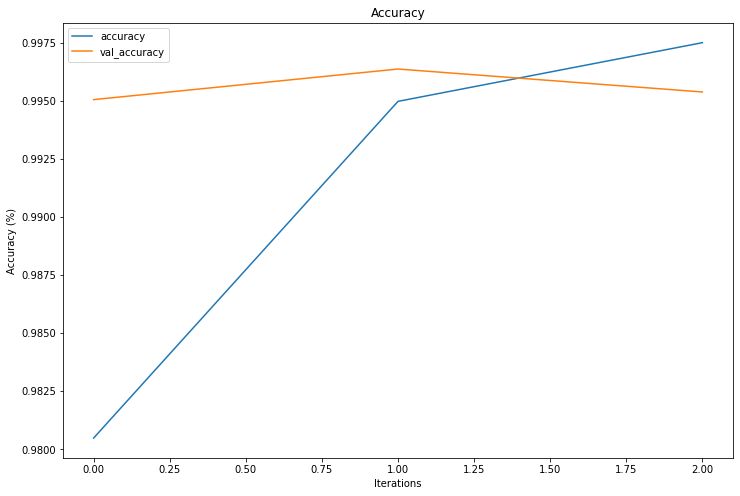

In [135]:
# Increase figure size:
plt.rcParams["figure.figsize"] = (12,8)

# Plot accuracy:
plt.plot(model_history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(model_history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.show()

In [123]:
def predict(text: str):
    encoded_input = tokenizer.encode(
        text,
        truncation=True,
        padding=True,
        max_length=MAX_CHAR_LENGTH,
        return_tensors="tf"
    )
    
    # Make prediction from logits:
    prediction = model.predict(encoded_input)['logits']
    prediction = tf.nn.softmax(prediction)
    prediction = np.argmax(prediction)
    
    return prediction

In [126]:
predictions = [predict(x) for x in test_set['text']]

In [137]:
test_set_y = test_set['label'].aggregateto_list()

In [138]:
f1_score(test_set_y, predictions, average="macro")

0.9958481613285883

In [141]:
print(classification_report(test_set_y, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1685
           1       1.00      1.00      1.00      1687

    accuracy                           1.00      3372
   macro avg       1.00      1.00      1.00      3372
weighted avg       1.00      1.00      1.00      3372

